# Quantile Regression POD

In [1]:
# import relevant module
import openturns as ot
import otpod
# enable display figure in notebook
try:
    %matplotlib inline
except:
    pass
from time import time

/calcul/home/dumas/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Generate data

In [2]:
N = 100
ot.RandomGenerator.SetSeed(123456)
defectDist = ot.Uniform(0.1, 0.6)
# normal epsilon distribution
epsilon = ot.Normal(0, 1.9)
defects = defectDist.getSample(N)
signalsInvBoxCox = defects * 43. + epsilon.getSample(N) + 2.5
# Inverse Box Cox transformation
invBoxCox = ot.InverseBoxCoxTransform(0.3)
signals = invBoxCox(signalsInvBoxCox)

## Build POD with quantile regression technique

In [3]:
# signal detection threshold
detection = 200.
# The POD with censored data actually builds a POD only on filtered data.
# A warning is diplayed in this case.
POD = otpod.QuantileRegressionPOD(defects, signals, detection,
                                  noiseThres=60., saturationThres=1700.,
                                  boxCox=True)

INFO:root:Censored data are not taken into account : the quantile regression model is only performed on filtered data.


### Quantile user-defined

In [4]:
# Default quantile values
print('Default quantile : ')
print(POD.getQuantile())
# Defining user quantile, they must range between 0 and 1.
POD.setQuantile([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95])
print('User-defined quantile : ')
print(POD.getQuantile())

Default quantile : 
[0.05   0.0965 0.143  0.1895 0.236  0.2825 0.329  0.3755 0.422  0.4685
 0.515  0.5615 0.608  0.6545 0.701  0.7475 0.794  0.8405 0.887  0.9335
 0.98  ]
User-defined quantile : 
[0.1  0.3  0.5  0.7  0.8  0.85 0.9  0.95]


### Running quantile regression POD

In [5]:
# Due to the bootstrap technique used to compute the confidence
# interval, the run takes few minutes.
# A progress bar is displayed (can be removed using setVerbose(False))
t0 = time()
POD = otpod.QuantileRegressionPOD(defects, signals, detection,
                                  boxCox=True)
POD.run()
print('Computing time : {:0.2f} s'.format(time()-t0))

/calcul/home/dumas/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/calcul/home/dumas/anaconda/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:237: RuntimeWarning: invalid value encountered in less_equal
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)


Computing defect quantile: [==------------------------------------------------] 4.00% 

/calcul/home/dumas/anaconda/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (300) reached.
  ") reached.", IterationLimitWarning)


Computing defect quantile: [===================-------------------------------] 38.00% 

/calcul/home/dumas/anaconda/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (300) reached.
  ") reached.", IterationLimitWarning)


Computing defect quantile: [==================================================] 100.00% Done
Computing time : 226.89 s


The computing time can be reduced by setting the simulation size attribute to 
another value. However the confidence interval is less accurate.

The number of quantile values can also be reduced to save time.

In [6]:
t0 = time()
PODsimulSize100 = otpod.QuantileRegressionPOD(defects, signals, detection,
                                  boxCox=True)
PODsimulSize100.setSimulationSize(100) # default is 1000
PODsimulSize100.run()
print('Computing time : {:0.2f} s'.format(time()-t0))

/calcul/home/dumas/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/calcul/home/dumas/anaconda/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:237: RuntimeWarning: invalid value encountered in less_equal
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)


Computing defect quantile: [==================================================] 100.00% Done
Computing time : 18.26 s


## Compute detection size

In [7]:
# Detection size at probability level 0.9
# and confidence level 0.95
print(POD.computeDetectionSize(0.9, 0.95))

# probability level 0.95 with confidence level 0.99
print(POD.computeDetectionSize(0.95, 0.99))

[a90 : 0.298115, a90/95 : 0.327459]
[a95 : 0.331931, a95/99 : 0.373163]


/calcul/home/dumas/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


## get POD Function

In [8]:
# get the POD model
PODmodel = POD.getPODModel()
# get the POD model at the given confidence level
PODmodelCl95 = POD.getPODCLModel(0.95)

# compute the probability of detection for a given defect value
print('POD : {:0.3f}'.format(PODmodel([0.3])[0]))
print('POD at level 0.95 : {:0.3f}'.format(PODmodelCl95([0.3])[0]))

POD : 0.899
POD at level 0.95 : 0.833


## Compute the pseudo R2 for a given quantile

In [9]:
print('Pseudo R2 for quantile 0.9 : {:0.3f}'.format(POD.getR2(0.9)))
print('Pseudo R2 for quantile 0.95 : {:0.3f}'.format(POD.getR2(0.95)))

Pseudo R2 for quantile 0.9 : 0.675
Pseudo R2 for quantile 0.95 : 0.656


/calcul/home/dumas/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


## Show POD graphs
### Mean POD and POD at confidence level with the detection size for a given probability level

/calcul/home/dumas/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/calcul/home/dumas/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


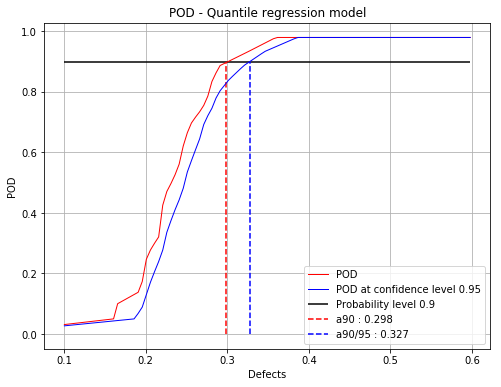

In [10]:
fig, ax = POD.drawPOD(probabilityLevel=0.9, confidenceLevel=0.95,
                      name='figure/PODQuantReg.png')
# The figure is saved in PODQuantReg.png
fig.show()

### Show the linear regression model at the given quantile 

/calcul/home/dumas/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/calcul/home/dumas/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


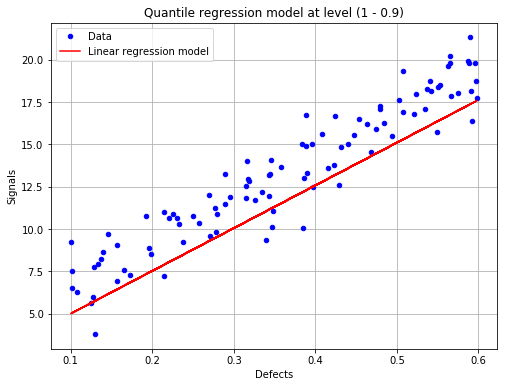

In [11]:
fig, ax = POD.drawLinearModel(0.9)
fig.show()